In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import xgboost as xgb
import joblib
from datetime import timedelta

from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf,pacf

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.utils import resample

In [34]:
#LOAD THE DATASET
df = pd.read_excel(r'Market Pricing (Feb 2023 - Nov 2024).xlsx', index_col='Timestamp', parse_dates=True)
df = df.apply(pd.to_numeric)
df.head(5)

,Supply Period,Correct Hour,Hour,Minimum,Maximum,Average
Timestamp,,,,,,
2023-02-26 00:00:00,1680220800000000000,0,1,4.509053,7.657594,5.686146
2023-02-26 01:00:00,1680220800000000000,1,2,3.708706,5.417432,4.225251
2023-02-26 02:00:00,1680220800000000000,2,3,3.981605,6.046616,4.355636
2023-02-26 03:00:00,1680220800000000000,3,4,4.022465,6.047146,4.493957
2023-02-26 04:00:00,1680220800000000000,4,5,3.621861,6.165480,4.542590


In [35]:
# Exploratory Data Analysis (EDA)
# The time series data shows no null values

print("Dataset Summary:")
print(df[['Minimum', 'Maximum', 'Average']].describe())
print("\nDataset Info:")
print(df.info())

Dataset Summary:
            Minimum       Maximum       Average
count  14880.000000  14880.000000  14880.000000
mean       3.079151      7.072934      4.574846
std        2.521912      8.874984      3.653212
min      -30.412698    -11.741057    -24.430888
25%        2.207312      3.265020      2.802622
50%        2.912964      4.194471      3.645847
75%        3.793671      7.500163      4.969665
max       27.953235    315.687285     99.865904

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14880 entries, 2023-02-26 00:00:00 to 2024-11-06 23:00:00
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Supply Period  14880 non-null  int64  
 1   Correct Hour   14880 non-null  int64  
 2   Hour           14880 non-null  int64  
 3   Minimum        14880 non-null  float64
 4   Maximum        14880 non-null  float64
 5   Average        14880 non-null  float64
dtypes: float64(3), int64(3)
memory usage

**Plot the average price of time series**
- The electricity market price in 1 hour interval shows a very volatile movement and extreme price movements that could be a potential outliers.

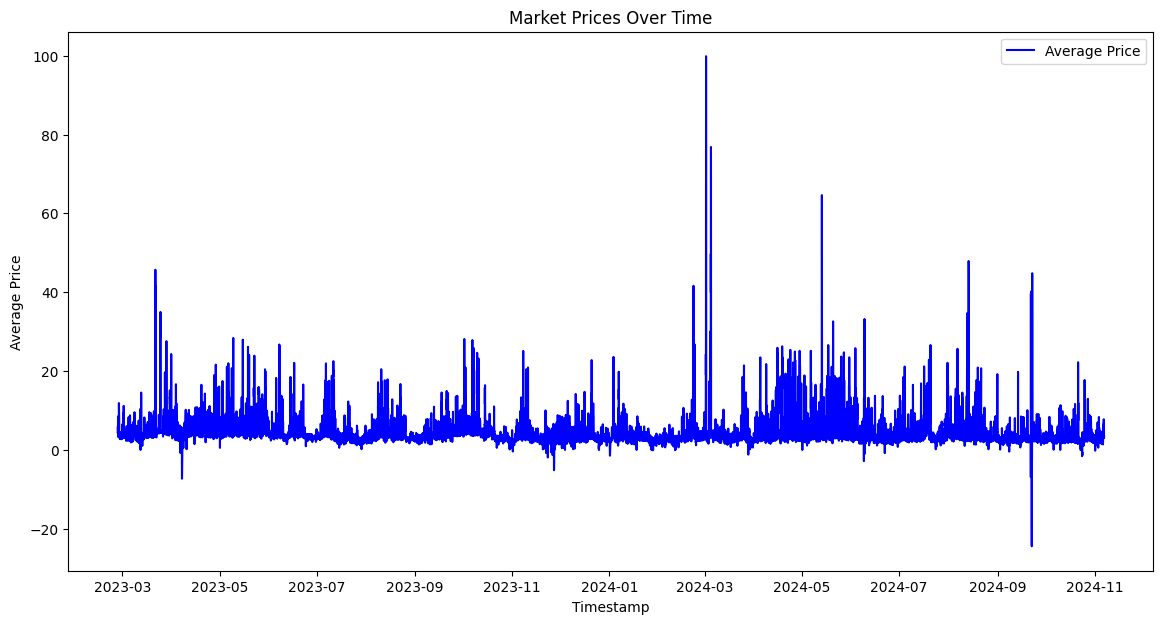

In [36]:
# Trend Analysis
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Average'], label='Average Price', color='blue')
plt.title('Market Prices Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Average Price')
plt.legend()
plt.show()


**AVERAGE PRICE DISTRIBUTION**
- The average price distribution is heavily skewed to the right, with most values concentrated near zero.
- There are some notable outliers, including a maximum price of 99 and a sharp drop to -24.
- Negative average prices are rare but significant, suggesting instances of surplus energy or unique market conditions.

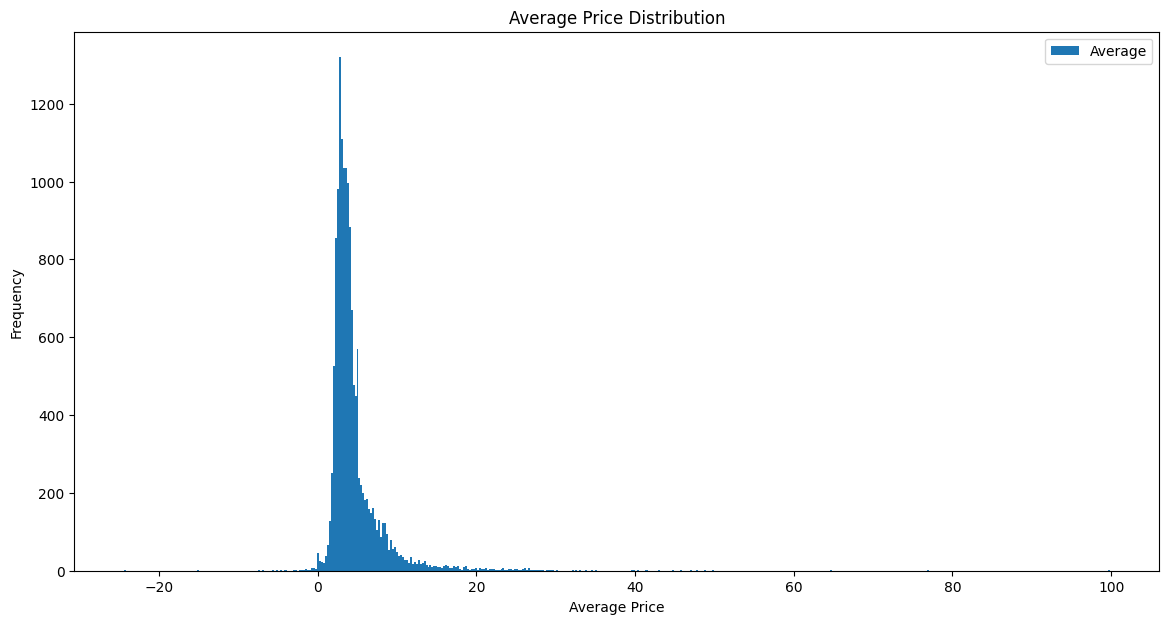

In [37]:
plt.figure(figsize=(14, 7))
df['Average'].plot(kind='hist', bins=500)
plt.title('Average Price Distribution')
plt.xlabel('Average Price')
plt.ylabel('Frequency')
plt.legend()
plt.show()

**VISUALIZE HOURLY ELECTRICITY MARKET PRICE TRENDS**

Hour with highest average price: 21 (7.30)
Hour with lowest average price: 6 (2.49)


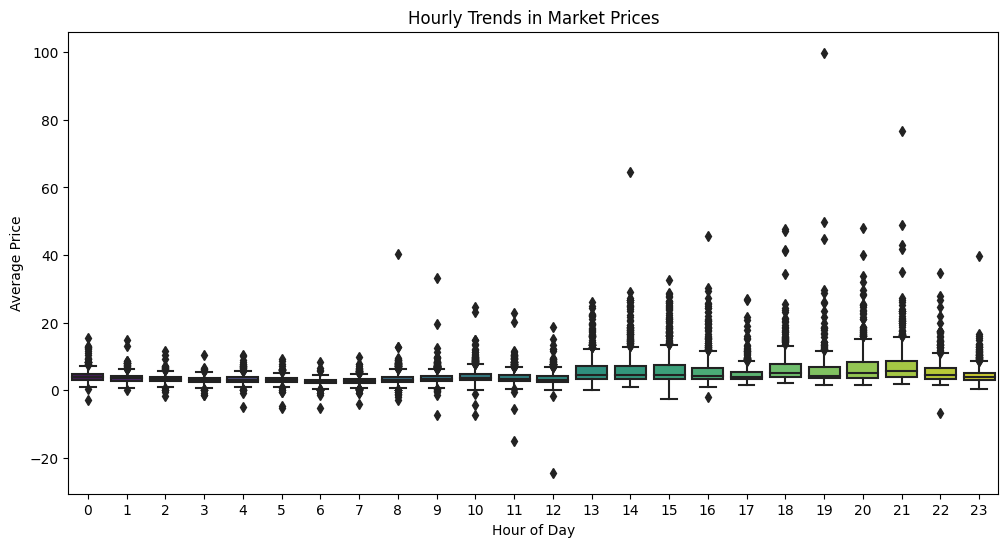

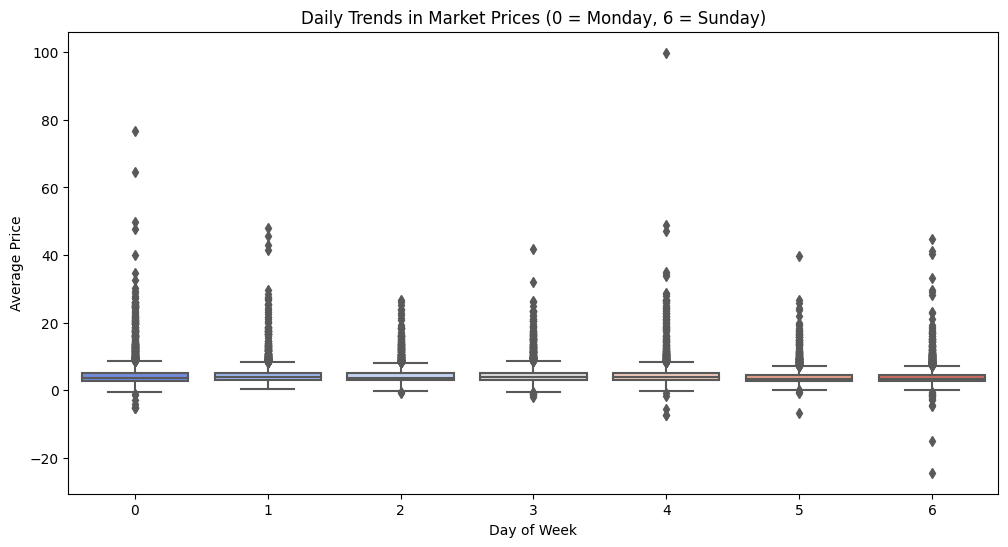

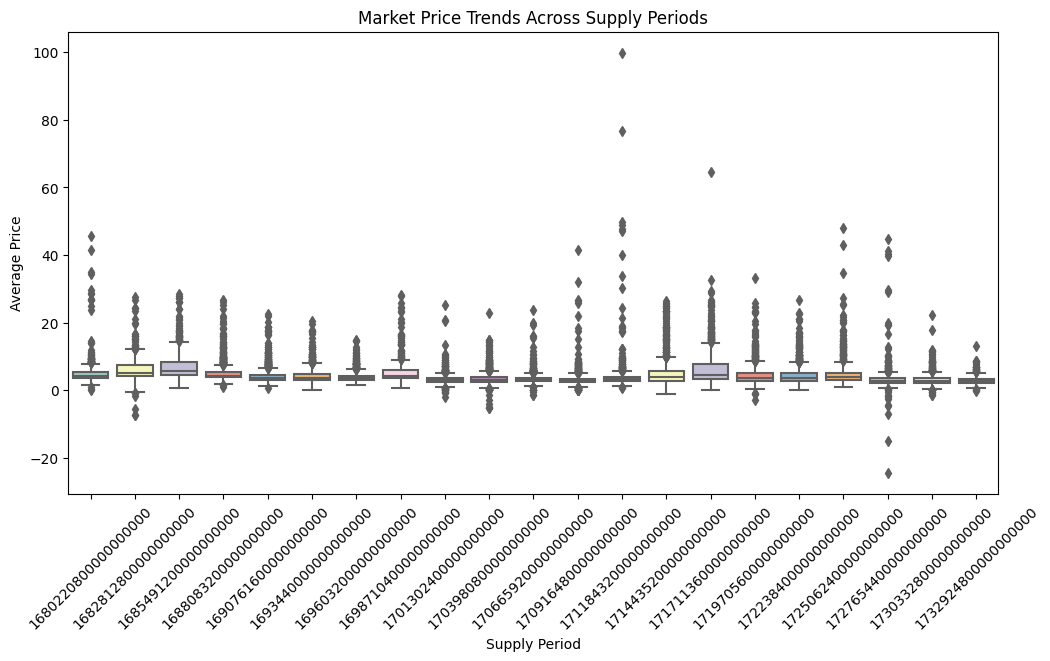

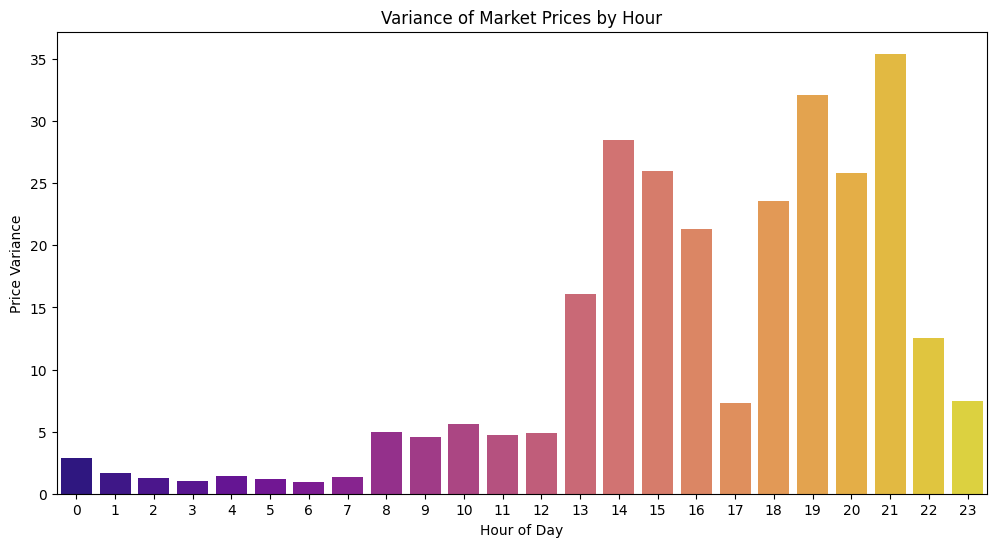

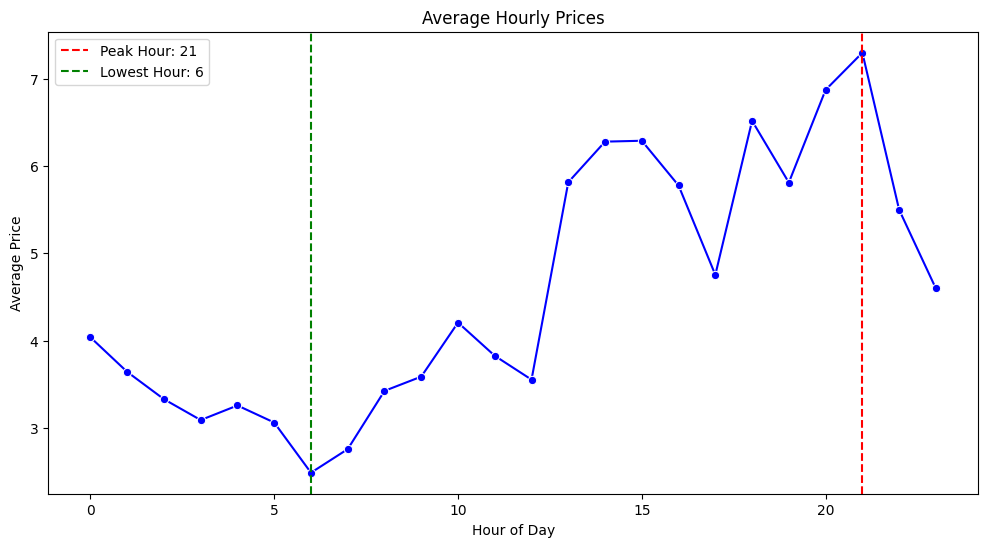

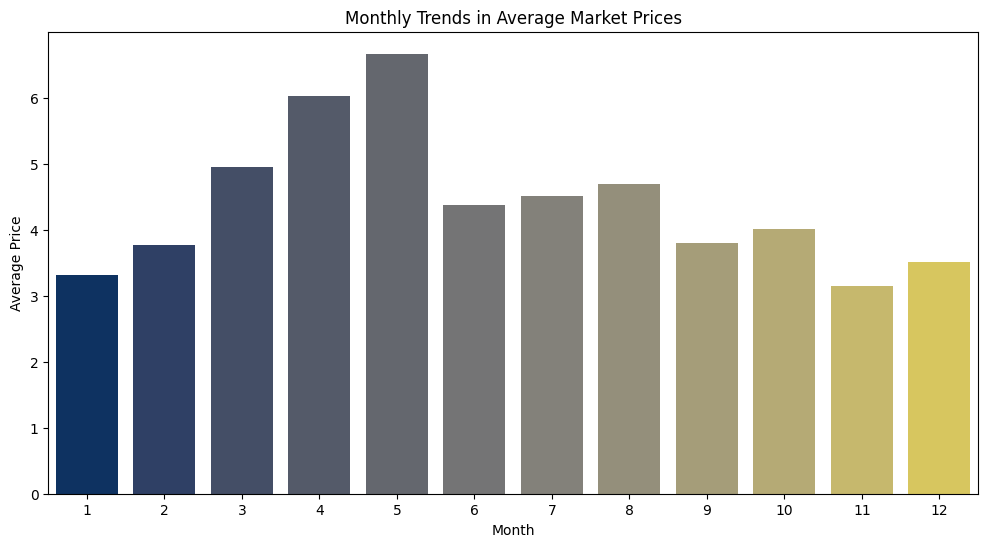

In [38]:
# Hourly Trends Patterns
df['Hour'] = df.index.hour
plt.figure(figsize=(12, 6))
sns.boxplot(x='Hour', y='Average', data=df.reset_index(), palette='viridis')
plt.title('Hourly Trends in Market Prices')
plt.xlabel('Hour of Day')
plt.ylabel('Average Price')

# Weekly Trends Patterns
df['DayOfWeek'] = df.index.dayofweek
plt.figure(figsize=(12, 6))
sns.boxplot(x='DayOfWeek', y='Average', data=df.reset_index(), palette='coolwarm')
plt.title('Daily Trends in Market Prices (0 = Monday, 6 = Sunday)')
plt.xlabel('Day of Week')
plt.ylabel('Average Price')

# Monthly Trends Patterns
df['Month'] = df.index.month
monthly_avg = df.groupby('Month')['Average'].mean()

# Price Trends Across Supply Periods
plt.figure(figsize=(12, 6))
sns.boxplot(x='Supply Period', y='Average', data=df.reset_index(), palette='Set3')
plt.title('Market Price Trends Across Supply Periods')
plt.xlabel('Supply Period')
plt.ylabel('Average Price')
plt.xticks(rotation=45)

# Variance of Prices by Hour
hourly_variance = df.groupby('Hour')['Average'].var()

plt.figure(figsize=(12, 6))
sns.barplot(x=hourly_variance.index, y=hourly_variance.values, palette='plasma')
plt.title('Variance of Market Prices by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Price Variance')

# Find Hours with Peak and Lowest Prices
hourly_avg = df.groupby('Hour')['Average'].mean()
peak_hour = hourly_avg.idxmax()
lowest_hour = hourly_avg.idxmin()

print(f"Hour with highest average price: {peak_hour} ({hourly_avg[peak_hour]:.2f})")
print(f"Hour with lowest average price: {lowest_hour} ({hourly_avg[lowest_hour]:.2f})")

# Plot Average Prices by Hour
plt.figure(figsize=(12, 6))
sns.lineplot(x=hourly_avg.index, y=hourly_avg.values, marker='o', color='b')
plt.title('Average Hourly Prices')
plt.axvline(peak_hour, color='r', linestyle='--', label=f'Peak Hour: {peak_hour}')
plt.axvline(lowest_hour, color='g', linestyle='--', label=f'Lowest Hour: {lowest_hour}')
plt.xlabel('Hour of Day')
plt.ylabel('Average Price')
plt.legend()

plt.figure(figsize=(12, 6))
sns.barplot(x=monthly_avg.index, y=monthly_avg.values, palette='cividis')
plt.title('Monthly Trends in Average Market Prices')
plt.xlabel('Month')
plt.ylabel('Average Price')
plt.show()


c:\Users\mlope\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


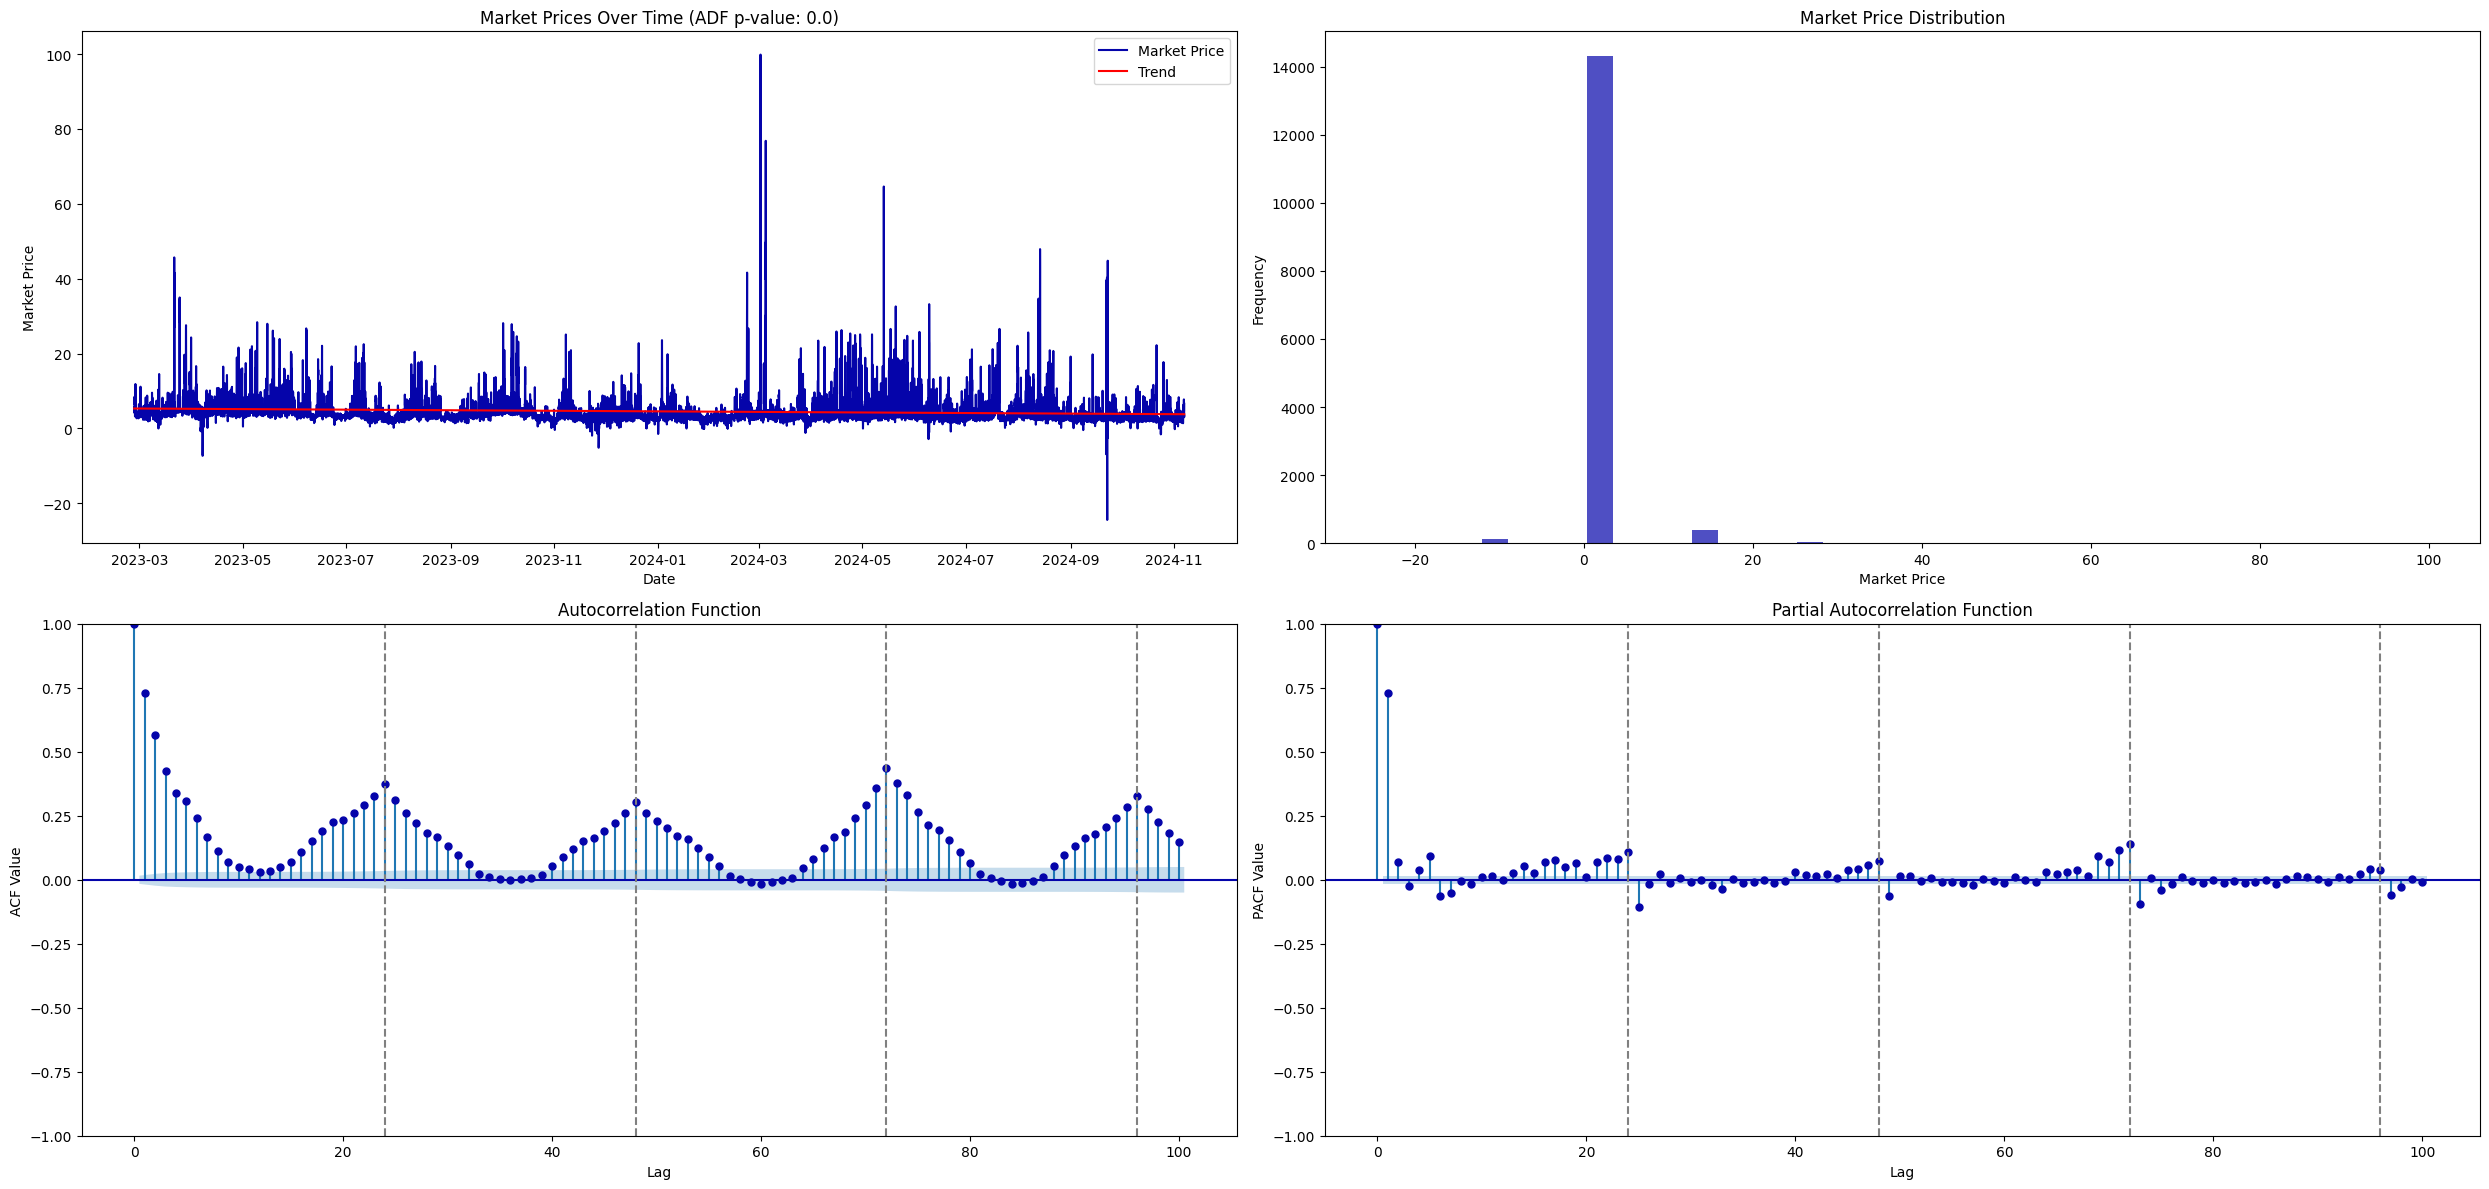

In [39]:
def get_trend(data):
    """
    Get the linear trend from the data, which shows the underlying
    trend component of the time series.
    """
    n = len(data.index)
    X = np.reshape(np.arange(0, n), (n, 1))
    y = np.array(data)
    model = LinearRegression()
    model.fit(X, y)
    trend = model.predict(X)
    return pd.Series(index=data.index, data=trend)

def ts_analysis_plots(data, n_lags=100):
    """
    Perform time-series analysis plots:
    - Original time series with linear trend
    - Histogram of market price distribution
    - Autocorrelation and partial autocorrelation functions
    """
    def plot_cf(ax, fn, data, n_lags):
        """
        Plot autocorrelation functions with emphasis on daily cycles.
        """
        fn(data, ax=ax, lags=n_lags, color="#0504aa")
        for i in range(1, 5):  # Highlight daily cycles (24-hour intervals)
            ax.axvline(x=24 * i, ymin=0.0, ymax=1.0, color='grey', ls="--")

    trend = get_trend(data)
    adf = adfuller(data)

    fig, axs = plt.subplots(2, 2, figsize=(25, 12))
    axs = axs.flat

    axs[0].plot(data, color='#0504aa', label="Market Price")
    axs[0].plot(trend, color="red", label="Trend")
    axs[0].set(xlabel="Date", ylabel="Market Price",
               title=f"Market Prices Over Time (ADF p-value: {round(adf[1], 6)})")
    axs[0].legend()

    axs[1].hist(data, bins=10, width=3, color='#0504aa', alpha=0.7)
    axs[1].set(xlabel="Market Price", ylabel="Frequency",
               title="Market Price Distribution")

    # Autocorrelation
    plot_cf(axs[2], plot_acf, data, n_lags)
    axs[2].set(xlabel="Lag", ylabel="ACF Value", title="Autocorrelation Function")

    # Partial autocorrelation 
    plot_cf(axs[3], plot_pacf, data, n_lags)
    axs[3].set(xlabel="Lag", ylabel="PACF Value", title="Partial Autocorrelation Function")

    plt.tight_layout()
    plt.show()

ts_analysis_plots(df['Average'])

2024-10-09 23:00:00


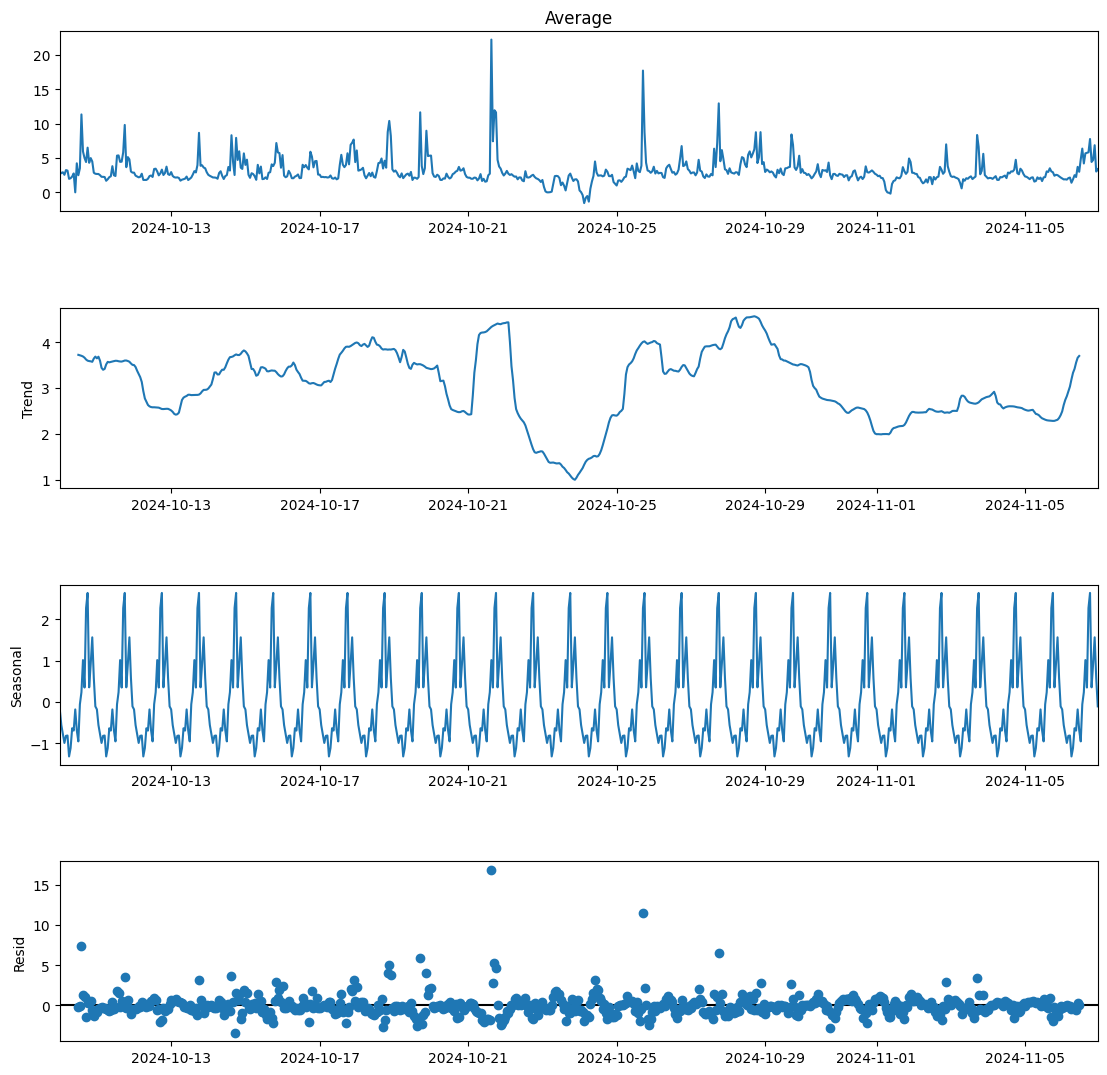

In [40]:
#Checks last 4 weeks of data for decompostion
energy_price = df['Average']
date = energy_price.index[-1] - pd.Timedelta(weeks=4)
print(date)
energy_price = energy_price[energy_price.index > date]
res = seasonal_decompose(energy_price, model='additive')
fig = res.plot()
fig.set_size_inches((12, 12))

**Check for Seasonality and Trends in the Time Series**

- Hourly Seasonality: High activity is observed during the afternoon until night, reflecting increased energy demand during these hours.
- Weekly Seasonality: Peak average prices occur on Mondays and weekdays, while weekends show significantly lower market prices.
- Monthly Seasonality: A noticeable surge in market prices is observed during the middle of the month, followed by a downward trend toward the end of the year.

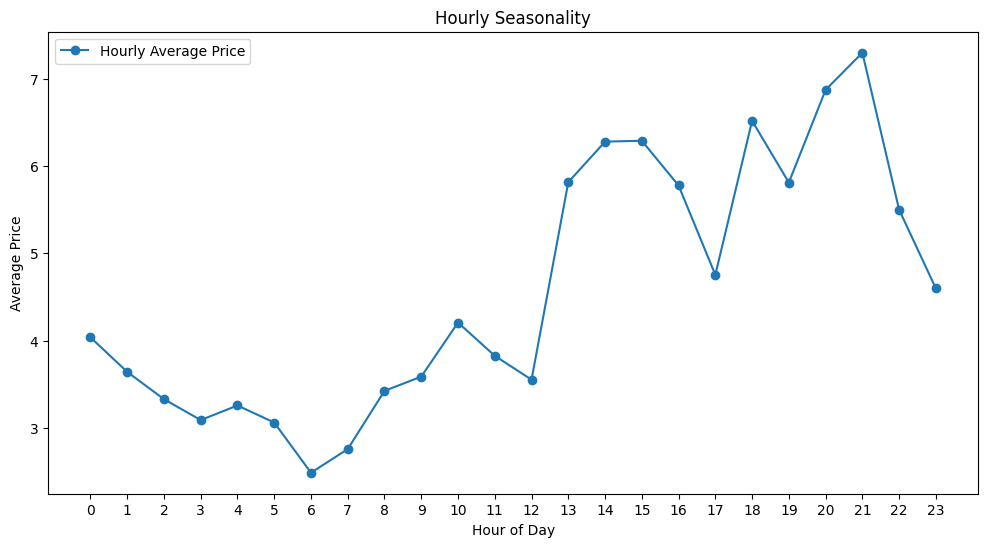

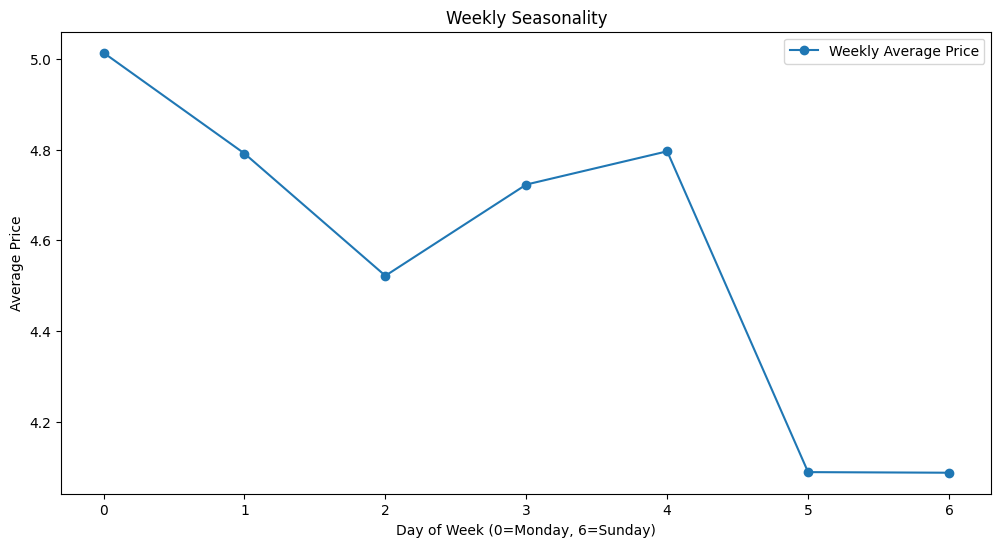

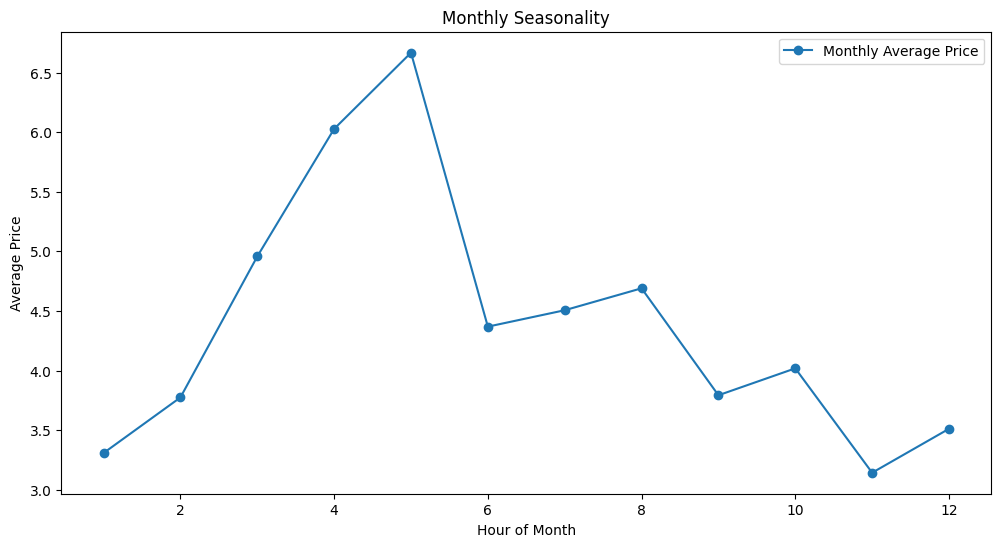

In [41]:
hourly_avg = df.groupby(df.index.hour)['Average'].mean()

plt.figure(figsize=(12, 6))
plt.plot(hourly_avg, marker='o', label='Hourly Average Price')
plt.title('Hourly Seasonality')
plt.xlabel('Hour of Day')
plt.ylabel('Average Price')
plt.xticks(range(24))
plt.legend()

weekly_avg = df.groupby(df.index.dayofweek)['Average'].mean()

plt.figure(figsize=(12, 6))
plt.plot(weekly_avg, marker='o', label='Weekly Average Price')
plt.title('Weekly Seasonality')
plt.xlabel('Day of Week (0=Monday, 6=Sunday)')
plt.ylabel('Average Price')
plt.legend()

monthly_avg = df.groupby(df.index.month)['Average'].mean()

plt.figure(figsize=(12, 6))
plt.plot(monthly_avg, marker='o', label='Monthly Average Price')
plt.title('Monthly Seasonality')
plt.xlabel('Hour of Month')
plt.ylabel('Average Price')
plt.legend()

plt.show()

Check for outliers in Time Series Dataset before feeding it to ML Model to avoid biased predictions and reduced model accuracy caused by extreme values that do not represent typical market behavior.

- Fetch the top 1% quantile of the average prices to identify extreme outliers in the time series data.
- Use the Z-score method to detect and remove data points that deviate significantly from the mean, ensuring a cleaner and more robust dataset for modeling.

In [42]:
# Define the threshold for anomalies top 1% of prices
anomaly_threshold = df['Average'].quantile(0.99)

# Identify anomalies
hourly_anomalies = df[df['Average'] > anomaly_threshold]

# df = df[df['Average'] <= anomaly_threshold]

print("Anomalies Detected:\n", hourly_anomalies)
# print("\nCleaned DataFrame:\n", df)


Anomalies Detected:
                            Supply Period  Correct Hour  Hour    Minimum  \
Timestamp                                                                 
2023-03-21 16:00:00  1680220800000000000            16    16  27.471277   
2023-03-21 17:00:00  1680220800000000000            17    17  25.269963   
2023-03-21 18:00:00  1680220800000000000            18    18  25.545920   
2023-03-21 19:00:00  1680220800000000000            19    19  25.269944   
2023-03-21 20:00:00  1680220800000000000            20    20  13.247806   
...                                  ...           ...   ...        ...   
2024-09-22 14:00:00  1727654400000000000            14    14  -5.078785   
2024-09-22 18:00:00  1727654400000000000            18    18   8.340031   
2024-09-22 19:00:00  1727654400000000000            19    19  11.549040   
2024-09-22 20:00:00  1727654400000000000            20    20   1.050199   
2024-10-21 15:00:00  1730332800000000000            15    15   2.793642   

   

In [43]:
from scipy.stats import zscore

# Remove outliers using z-score 
df['zscore'] = zscore(df['Average'])  # Compute z-scores
threshold = 3 
df = df[(df['zscore'] > -threshold) & (df['zscore'] < threshold)]  
df = df.drop(columns=['zscore'])

print(df)

                           Supply Period  Correct Hour  Hour   Minimum  \
Timestamp                                                                
2023-02-26 00:00:00  1680220800000000000             0     0  4.509053   
2023-02-26 01:00:00  1680220800000000000             1     1  3.708706   
2023-02-26 02:00:00  1680220800000000000             2     2  3.981605   
2023-02-26 03:00:00  1680220800000000000             3     3  4.022465   
2023-02-26 04:00:00  1680220800000000000             4     4  3.621861   
...                                  ...           ...   ...       ...   
2024-11-06 19:00:00  1732924800000000000            19    19  3.906353   
2024-11-06 20:00:00  1732924800000000000            20    20  3.000403   
2024-11-06 21:00:00  1732924800000000000            21    21  2.676316   
2024-11-06 22:00:00  1732924800000000000            22    22  2.483913   
2024-11-06 23:00:00  1732924800000000000            23    23  2.167429   

                       Maximum   Aver

**FEATURES CREATION**

Lag features capture temporal dependencies in the data by including values from previous time steps:
- Lag_1, Lag_2, Lag_24: Based on the partial correlation the time series hourly data is heavily relies to the previous lag prices and daily price because of its short term movement.

Adding time-related variables helps the model understand periodicity and seasonality:
- Hour, Day, Month, Year, DayOfWeek: Extracted from the datetime index to provide a temporal context for the observations.
- WeekOfYear: Helps capture trends specific to certain weeks.

- IsPeakHour: Indicates whether the observation falls in the late evening (20:00–23:00), when prices tend to surge.
- IsActiveHour: Marks the hours with consistent high activity (13:00–23:00).
- IsLowActivityHour: Captures early morning periods (00:00–06:00) when market activity is low.

- IsHighSpikeMonth: Identifies months with typically higher prices (March, April, May) to capture seasonal spikes.

- PeakHour_HighSpikeMonth: Combines peak hours with high-spike months to highlight specific high-demand periods.
- ActiveHour_HighSpikeMonth: Interaction between active hours and high-spike months.

- RollingMean, RollingStd, RollingMedian: Average, standard deviation, and median over a 24-hour rolling window.
- RollingMin, RollingMax: Minimum and maximum prices over a 24-hour rolling window.

- CumulativeSum: Total sum of the target column up to the current observation.
- CumulativeMean: Running mean of the target column.

- Hour_sin, Hour_cos: Sine and cosine transformations of the hour, representing daily cycles.

HourlyVarianceCategory: Groups hours into variance categories (high, medium, low) based on typical price fluctuations:
- High Variance: Late evening hours (20:00–23:00)
- Medium Variance: Afternoon hours (13:00–16:00)
- Low Variance: Early morning hours (00:00–03:00)

In [44]:
def add_lags_futures(df):
    df = df.copy()

    target_map = df['Average'].to_dict()

    df.loc[:, 'Lag_1'] = (df.index - pd.Timedelta('4380 hours')).map(target_map)
    df.loc[:, 'Lag_2'] = df['Lag_1'].shift(2)
    df.loc[:, 'Lag_24'] = df['Lag_2'].shift(24)

    return df


def add_lags(df, lags=[1, 2, 24]):
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("The DataFrame index must be a DatetimeIndex.")

    df = df.copy()

    for lag in lags:
        df[f'Lag_{lag}'] = df['Average'].shift(lag)

    return df


def preprocess_features(features_df, target_column, pacf_threshold=0.2, pacf_lags=200, rolling_window=24):
    """
    Preprocess the dataset by adding lag features, time-based features, rolling statistics,
    and other derived features.

    Parameters:
    - df (pd.DataFrame): Input DataFrame with a datetime index and target column.
    - target_column (str): Name of the target column for lag and rolling calculations.
    - pacf_threshold (float): Threshold for PACF significance.
    - pacf_lags (int): Number of lags to consider for PACF.
    - rolling_window (int): Window size for rolling statistics.

    Returns:
    - pd.DataFrame: Transformed DataFrame with new features.
    """ 
    features_df = features_df.copy()

    # Add time-based features
    features_df['Hour'] = features_df.index.hour
    features_df['Day'] = features_df.index.day
    features_df['Month'] = features_df.index.month
    features_df['DayOfWeek'] = features_df.index.dayofweek
    features_df['Year'] = features_df.index.year
    features_df['WeekOfYear'] = features_df.index.isocalendar().week

    # Peak hour indicator
    features_df['IsPeakHour'] = features_df['Hour'].apply(lambda x: 1 if 20 <= x <= 23 else 0)

    # Active and low activity hours
    features_df['IsActiveHour'] = features_df['Hour'].apply(lambda x: 1 if 13 <= x <= 23 else 0)
    features_df['IsLowActivityHour'] = features_df['Hour'].apply(lambda x: 1 if 0 <= x <= 6 else 0)

    # High-spike months indicator
    features_df['IsHighSpikeMonth'] = features_df['Month'].apply(lambda x: 1 if x in [3, 4, 5] else 0)

    # Interaction features
    features_df['PeakHour_HighSpikeMonth'] = features_df['IsPeakHour'] * features_df['IsHighSpikeMonth']
    features_df['ActiveHour_HighSpikeMonth'] = features_df['IsActiveHour'] * features_df['IsHighSpikeMonth']

    # Rolling statistics
    features_df[f'RollingMean_{rolling_window}h'] = features_df[target_column].rolling(window=rolling_window).mean()
    features_df[f'RollingStd_{rolling_window}h'] = features_df[target_column].rolling(window=rolling_window).std()
    features_df[f'RollingMedian_{rolling_window}h'] = features_df[target_column].rolling(window=rolling_window).median()
    features_df[f'RollingMin_{rolling_window}h'] = features_df[target_column].rolling(window=rolling_window).min()
    features_df[f'RollingMax_{rolling_window}h'] = features_df[target_column].rolling(window=rolling_window).max()

    # Cumulative statistics
    features_df['CumulativeSum'] = features_df[target_column].cumsum()
    features_df['CumulativeMean'] = features_df[target_column].expanding().mean()

    # Hourly cyclic features
    features_df['Hour_sin'] = np.sin(2 * np.pi * features_df.index.hour / 24)
    features_df['Hour_cos'] = np.cos(2 * np.pi * features_df.index.hour / 24)

    # Hourly variance category
    hourly_variance = {20: 3, 21: 3, 22: 3, 23: 3, 13: 2, 14: 2, 15: 2, 16: 2, 0: 1, 1: 1, 2: 1, 3: 1}
    features_df.loc[:, 'HourlyVarianceCategory'] = features_df['Hour'].map(hourly_variance).fillna(0)

    return features_df

**DATA TRAIN & TEST SPLIT**
- Train from the start of the dataset until 2024-10 and test will be the last month of the data. 

Shape of train_set : (14376, 30)
Shape of test_set : (141, 30)
Train index range: 2023-02-26 00:00:00 to 2024-10-31 23:00:00
Test index range: 2024-11-01 00:00:00 to 2024-11-06 23:00:00


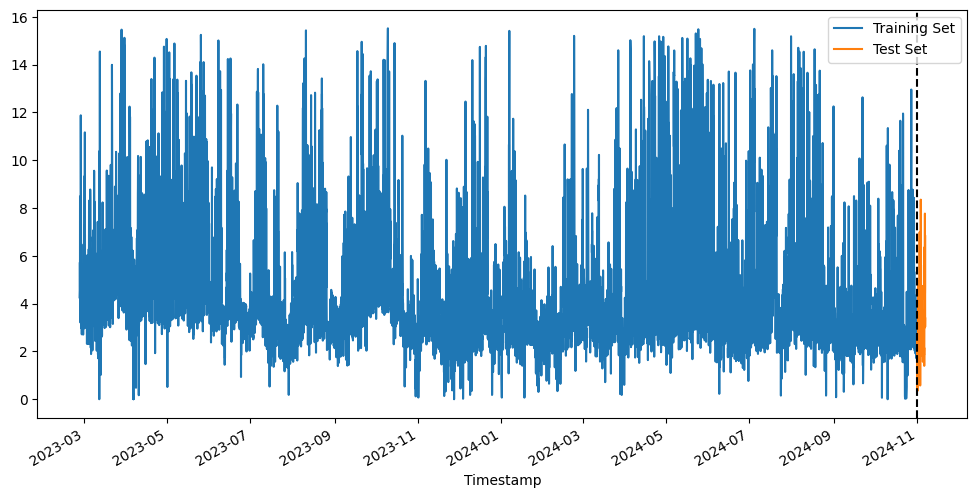

In [45]:
df = preprocess_features(df, target_column='Average')
df = add_lags(df)

# Filter out negative target values
df = df[df['Average'] >= 0]

# Split dataset into training and testing
train = df.loc[:'2024-10']
test = df.loc['2024-11']

print(f"Shape of train_set : {train.shape}")
print(f"Shape of test_set : {test.shape}")

print(f"Train index range: {train.index.min()} to {train.index.max()}")
print(f"Test index range: {test.index.min()} to {test.index.max()}")

fig, ax =plt.subplots(figsize=(12,6))
train['Average'].plot(ax=ax, label = 'Training Set')
test['Average'].plot(ax=ax, label = 'Test Set')
ax.axvline('2024-11', color = 'black', ls= '--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

**MODELLING AND HYPER PARAMETER TUNING**

The time series dataset exhibits significant noise, short-term fluctuations, and complex seasonality patterns due to hourly market price variations. 
To effectively model these characteristics, I have chosen XGBoost Regressor, 
which is highly efficient for handling non-linear dependencies and capturing short-term movements in data. 

Applied a StandardScaler to standardize the training and test datasets. 
Note that the scaler was fit only on the training set and applied to the test set separately to prevent data leakage.

Standardizing the dataset ensures that all features are on the same scale, which is crucial for gradient-boosted algorithms to converge efficiently during training.

Use Optuna, an advanced optimization library, to identify the best hyperparameters for the XGBoost Regressor,
ensuring the model is fine-tuned to capture the noisy, short-term variations in the time series.

Evaluation Strategy:
- Used TimeSeriesSplit with 5 splits to ensure that each validation set consists of data points occurring after the training set. 
This prevents data leakage and mimics the real-world scenario of forecasting future data.


In [46]:
# Define the optimization function using TimeSeriesSplit
def optimize_xgboost(trial):
    params = {
        'objective': 'reg:squarederror',
        'booster': 'gbtree',
        'n_estimators': trial.suggest_int('n_estimators', 100, 500, step=50),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, step=0.01),
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0, step=0.1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0, step=0.1),
        'gamma': trial.suggest_float('gamma', 0, 5, step=0.1),
        'lambda': trial.suggest_float('lambda', 1e-3, 10, log=True),
        'alpha': trial.suggest_float('alpha', 1e-3, 10, log=True),
    }

    tscv = TimeSeriesSplit(n_splits=5)
    rmse_scores = []

    for train_index, val_index in tscv.split(X_train_scaled):
        X_t, X_val = X_train_scaled[train_index], X_train_scaled[val_index]
        y_t, y_val = y_train[train_index], y_train[val_index]

        model = xgb.XGBRegressor(**params, random_state=42)
        model.fit(X_t, y_t)
        y_pred = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmse_scores.append(rmse)

    return np.mean(rmse_scores)

# Define features and target
features = ['Hour','Day','Month', 'Hour_sin', 'Hour_cos', 'HourlyVarianceCategory','Lag_1', 'Lag_24']

print(features)
target = 'Average'

X_train = train[features].values
y_train = train[target].values
X_test = test[features].values
y_test = test[target].values

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Optimize hyperparameters with Optuna
study = optuna.create_study(direction='minimize')
study.optimize(optimize_xgboost, n_trials=50)

# Best parameters from Optuna
best_params = study.best_params
print("Best Parameters:", best_params)

# Train the final XGBoost model with the best parameters
model = xgb.XGBRegressor(**best_params, random_state=42)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

[I 2024-12-25 22:33:27,909] A new study created in memory with name: no-name-64deebdf-1f44-4302-ac7a-18c33e73a84e


['Hour', 'Day', 'Month', 'Hour_sin', 'Hour_cos', 'HourlyVarianceCategory', 'Lag_1', 'Lag_24']


[I 2024-12-25 22:33:29,244] Trial 0 finished with value: 1.3909223997832318 and parameters: {'n_estimators': 450, 'learning_rate': 0.17, 'max_depth': 7, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 3.7, 'lambda': 0.003004038470466688, 'alpha': 0.00286221690766209}. Best is trial 0 with value: 1.3909223997832318.
[I 2024-12-25 22:33:30,632] Trial 1 finished with value: 1.3592595681290565 and parameters: {'n_estimators': 400, 'learning_rate': 0.05, 'max_depth': 8, 'subsample': 1.0, 'colsample_bytree': 0.9, 'gamma': 3.6, 'lambda': 1.3161260436304978, 'alpha': 0.04957386594314827}. Best is trial 1 with value: 1.3592595681290565.
[I 2024-12-25 22:33:31,423] Trial 2 finished with value: 1.356773927776346 and parameters: {'n_estimators': 450, 'learning_rate': 0.24000000000000002, 'max_depth': 5, 'subsample': 1.0, 'colsample_bytree': 0.9, 'gamma': 4.800000000000001, 'lambda': 0.0046959498671515255, 'alpha': 0.022013437353603886}. Best is trial 2 with value: 1.356773927776346.
[I 2024-12

Best Parameters: {'n_estimators': 300, 'learning_rate': 0.17, 'max_depth': 3, 'subsample': 1.0, 'colsample_bytree': 0.9, 'gamma': 1.2000000000000002, 'lambda': 3.6887340026491935, 'alpha': 0.2848342852789277}


In [47]:
# Model Evaluation
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"Evaluation Metrics on Test Set:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

Evaluation Metrics on Test Set:
MAE: 0.49
RMSE: 0.83
MAPE: 19.12%


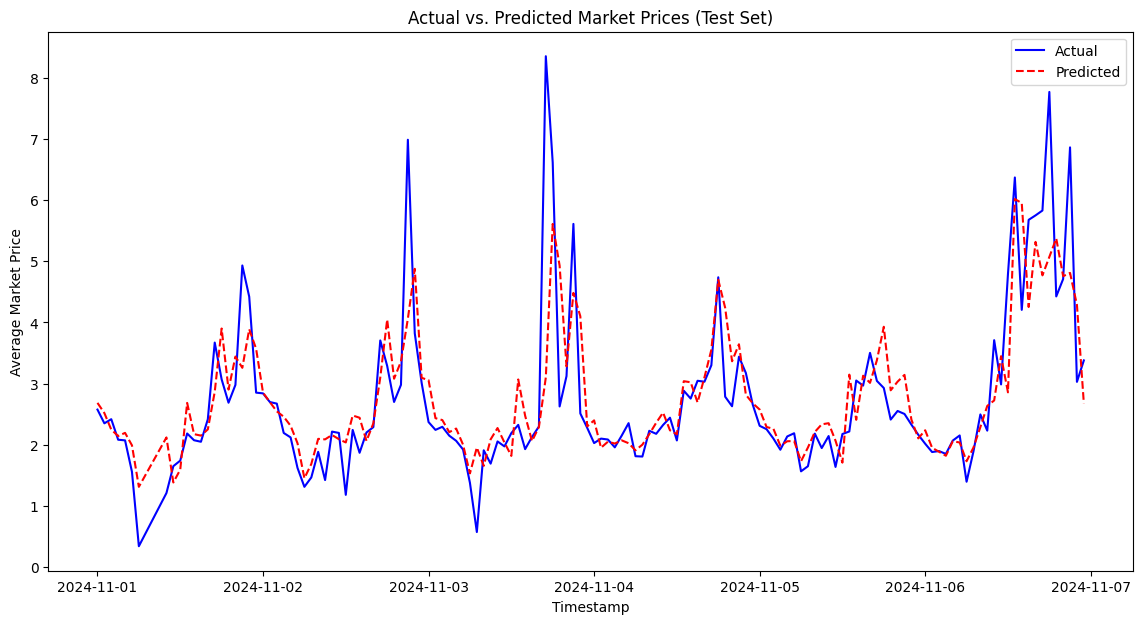

In [48]:
# Visualize actual vs. predicted values for the test set
plt.figure(figsize=(14, 7))
plt.plot(test.index, y_test, label='Actual', color='blue')
plt.plot(test.index, y_pred, label='Predicted', color='red', linestyle='dashed')
plt.title('Actual vs. Predicted Market Prices (Test Set)')
plt.xlabel('Timestamp')
plt.ylabel('Average Market Price')
plt.legend()
plt.show()


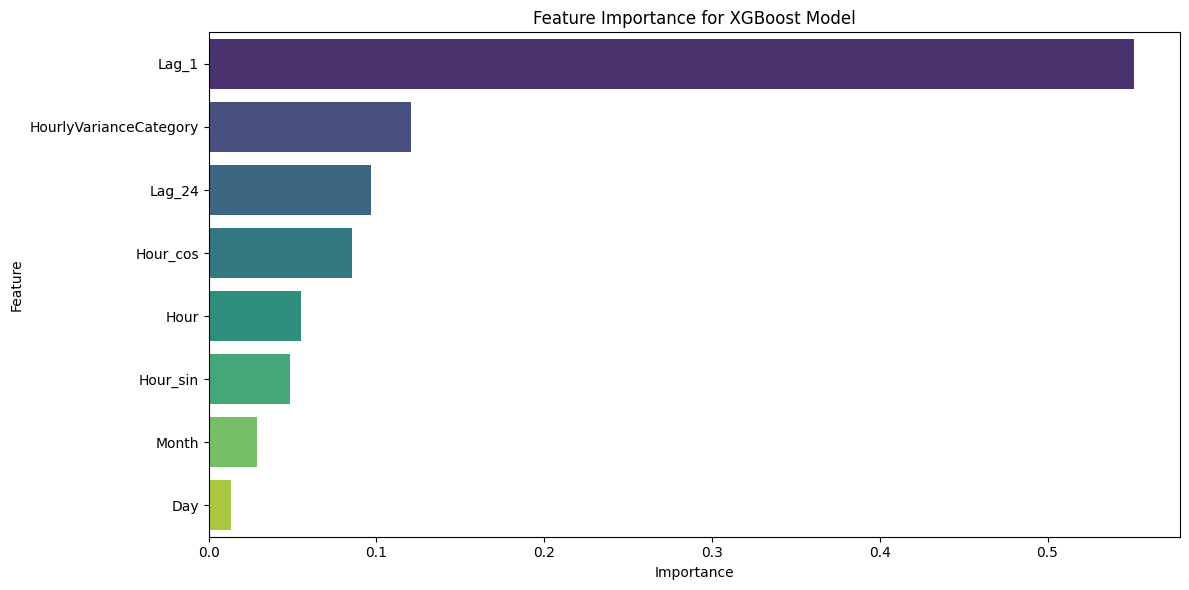

                  Feature  Importance
6                   Lag_1    0.551403
5  HourlyVarianceCategory    0.120722
7                  Lag_24    0.097061
4                Hour_cos    0.085469
0                    Hour    0.054881
3                Hour_sin    0.048568
2                   Month    0.028678
1                     Day    0.013219


In [49]:
# Feature Importance
importances = model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance_df, x='Importance', y='Feature', palette='viridis')
plt.title('Feature Importance for XGBoost Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

print(feature_importance_df)

**Forecast 6 Months to the Future**
- To forecast hourly values for the next six months i retrain the model on the entire available dataset, generating the required time intervals, and preparing the necessary features. This approach ensures the model captures all historical patterns and trends before making future predictions. Additionally, we will incorporate confidence intervals to evaluate the forecast's uncertainty and provide a range for the expected values.

In [50]:
def add_confidence_intervals(model, future_features, n_simulations=100, alpha=0.05):
    """
    Add confidence intervals to predictions using bootstrap resampling.

    Parameters:
    - model: Trained XGBoost model.
    - future_features (pd.DataFrame): DataFrame of features for future predictions.
    - n_simulations (int): Number of bootstrap simulations. Default is 100.
    - alpha (float): Significance level for confidence intervals. Default is 0.05.

    Returns:
    - tuple: Lower and upper bounds for predictions.
    """
    bootstrap_preds = []
    for _ in range(n_simulations):
        boot_features = resample(future_features, random_state=np.random.randint(0, 10000))
        
        boot_preds = model.predict(boot_features)
        bootstrap_preds.append(boot_preds)
    
    bootstrap_preds = np.array(bootstrap_preds)
    
    # Calculate confidence intervals
    lower_bound = np.percentile(bootstrap_preds, alpha / 2 * 100, axis=0)
    upper_bound = np.percentile(bootstrap_preds, (1 - alpha / 2) * 100, axis=0)
    
    return lower_bound, upper_bound

df = preprocess_features(df, target_column='Average')
df = add_lags(df)

x_all = df[features]
y_all = df[target]

reg = xgb.XGBRFRegressor(booster='gbtree', objective='reg:squarederror', random_state=42)
reg.fit(x_all, y_all, eval_set=[(x_all, y_all)], verbose=100)

# Future prediction setup
start = df.index.max() + timedelta(hours=1)
future_hours = 6 * 30 * 24  # 6 months worth of hourly data

# Generate future timestamps
future_timestamps = pd.date_range(start=start, periods=future_hours, freq='H')
future_data = pd.DataFrame(index=future_timestamps)
future_data['isFuture'] = True

df['isFuture'] = False
combined_data = pd.concat([df, future_data])

combined_data = preprocess_features(combined_data, target_column='Average')
combined_data = add_lags_futures(combined_data)

future_df = combined_data.query('isFuture').copy()

# Predict and add confidence intervals
future_df['pred'] = reg.predict(future_df[features])
lower, upper = add_confidence_intervals(reg, future_df[features])
future_df['lower_bound'] = lower
future_df['upper_bound'] = upper

# Save the forecasted results
future_df[['pred', 'lower_bound', 'upper_bound']].to_csv('6_month_forecast.csv', index=True)


[0]	validation_0-rmse:1.32106


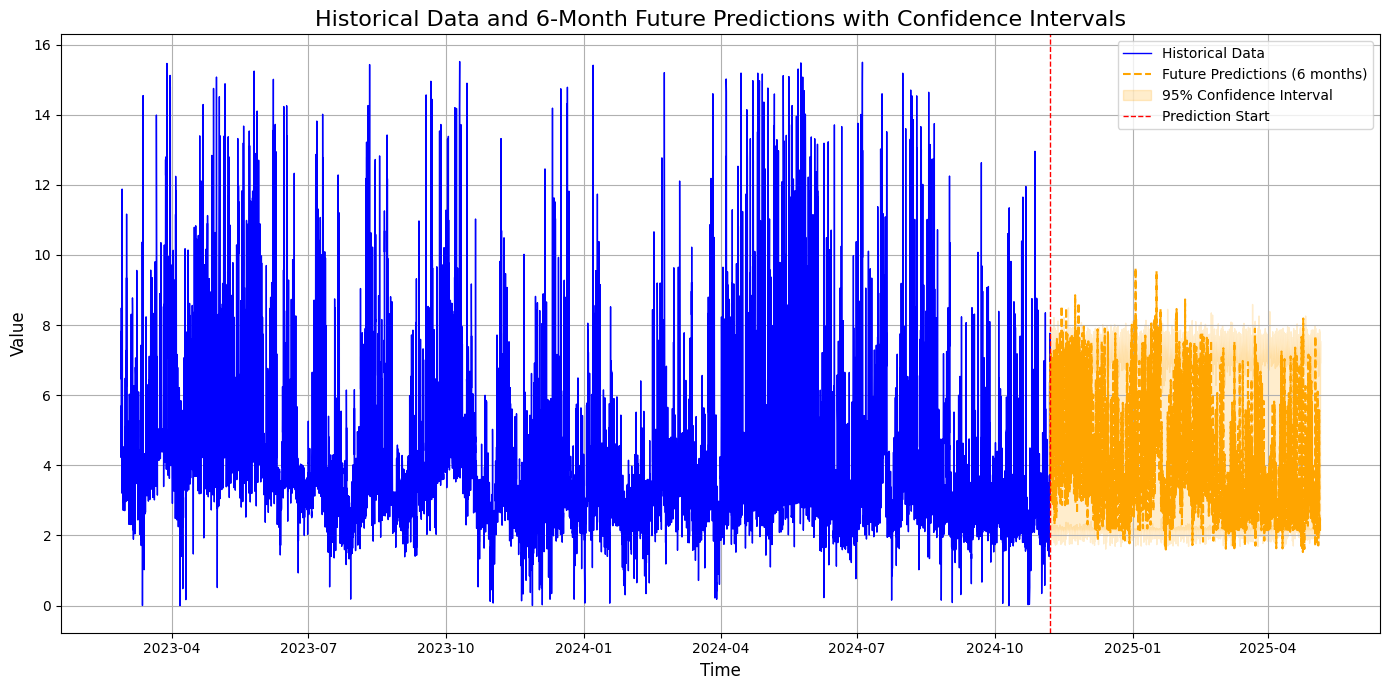

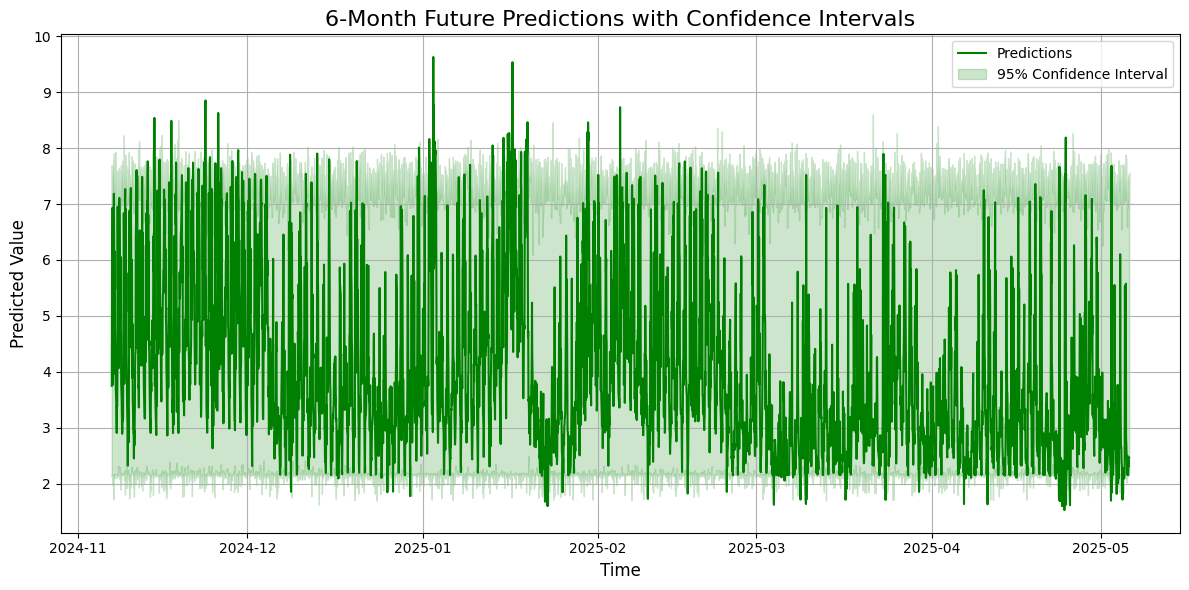

In [51]:
# Plot historical data and predictions with confidence intervals
plt.figure(figsize=(14, 7))
plt.plot(combined_data.index, combined_data['Average'], label='Historical Data', color='blue', linewidth=1)
plt.plot(future_df.index, future_df['pred'], label='Future Predictions (6 months)', color='orange', linestyle='--', linewidth=1.5)
plt.fill_between(future_df.index, future_df['lower_bound'], future_df['upper_bound'], color='orange', alpha=0.2, label='95% Confidence Interval')
plt.axvline(x=start, color='red', linestyle='--', linewidth=1, label='Prediction Start')
plt.title('Historical Data and 6-Month Future Predictions with Confidence Intervals', fontsize=16)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot only future predictions with confidence intervals
plt.figure(figsize=(12, 6))
plt.plot(future_df.index, future_df['pred'], label='Predictions', color='green', linewidth=1.5)
plt.fill_between(future_df.index, future_df['lower_bound'], future_df['upper_bound'], color='green', alpha=0.2, label='95% Confidence Interval')
plt.title('6-Month Future Predictions with Confidence Intervals', fontsize=16)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Predicted Value', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [52]:
# Save the trained model
joblib.dump(reg, 'xgboost_model_1.pkl')

['xgboost_model_1.pkl']